<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/DNN_photoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use neural network algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.



# Load some libraries

In [1]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 31.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [3]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

# Clean the data

In [4]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['objID', 'ra', 'dec', 'z', 'zerr', 'class', 'mag_r', 'mag_g', 'mag_i', 'mag_u', 'mag_z']


# for photo-z work
# The target/label values are spectroscopic redshifts

In [6]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

# let's load these into an input array
inputs = np.zeros((len(d), len(mags)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

targets = np.array(f2(d['z']))

In [31]:
# normalise inputs
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# we will split the data into a trainind and testing sample.


In [32]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.1, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (148452, 5)
Training outputs:  (148452,)
Testing inputs:  (16495, 5)
Testing outputs:  (16495,)


# Import Tensorflow

In [33]:
import tensorflow as tf

In [34]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(5,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

lr = 1.E-3

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(lr))

In [35]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64)

Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x7caa8e471b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


1856/1856 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0176 - val_loss: 0.0130
Epoch 2/10
 535/1856 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

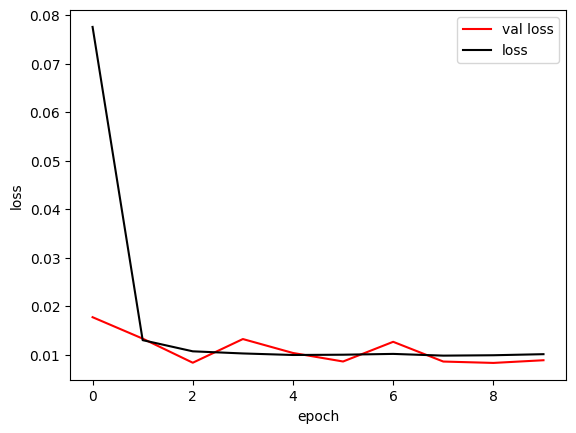

In [20]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

1031/1031 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


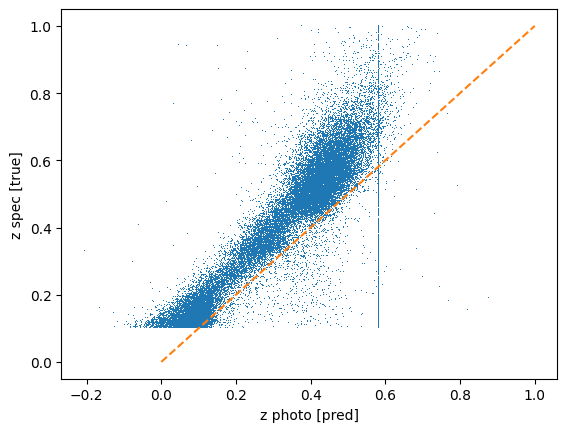

In [16]:
pred=model.predict(x_test).squeeze()
pred
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()

(0.3, 0.65)

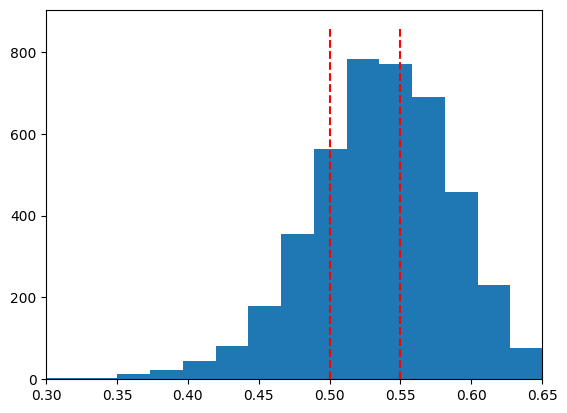

In [ ]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.build()

In [ ]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
1517/1517 [==============================] - 8s 4ms/step - loss: 0.0816 - val_loss: 0.0558
Epoch 2/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0528 - val_loss: 0.0473
Epoch 3/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0495 - val_loss: 0.0579
Epoch 4/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0486 - val_loss: 0.0449
Epoch 5/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0481 - val_loss: 0.0453
Epoch 6/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0470 - val_loss: 0.0444
Epoch 7/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0465 - val_loss: 0.0449
Epoch 8/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0460 - val_loss: 0.0442
Epoch 9/10
1517/1517 [==============================] - 7s 4ms/step - loss: 0.0454 - val_loss: 0.0570
Epoch 10/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.045

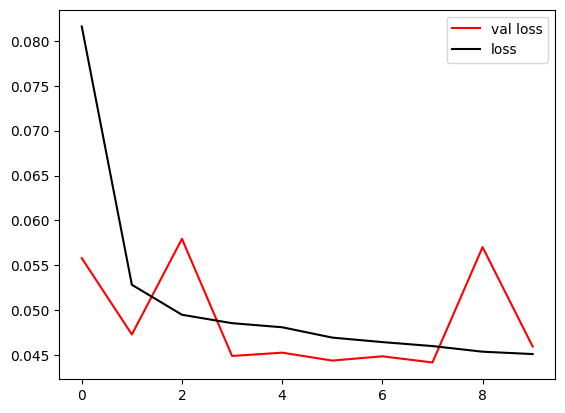

In [ ]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.legend()

948/948 [==============================] - 2s 2ms/step


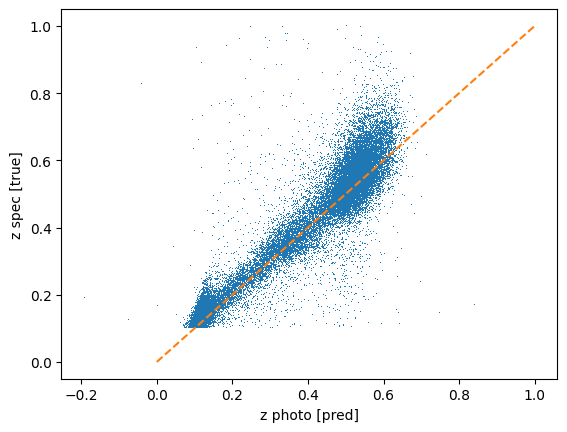

In [ ]:
pred=model.predict(x_test).squeeze()
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()


(0.3, 0.65)

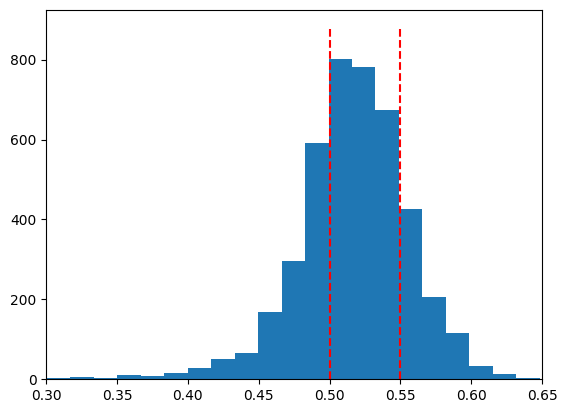

In [ ]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))